In [37]:
# import notebooks
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st
from statistics import multimode
import warnings
import os

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


<br>
<center><b style="color:black;font-size:40px;"> Homework 5: ANOVAs </b></center>  
<br>

**Interpreting p-values**  
<br>
**Null** hypothesis: $H_{0}: \bar{x}=\mu$  
**Left** tailed test **alternative** hypothesis: $H_{1}: \bar{x}<\mu$  
**Right** tailed test **alternative** hypothesis: $H_{1}: \bar{x}>\mu$  
<br>
$p<\alpha \rightarrow $ Reject $H_{0}$  
$p>\alpha \rightarrow$ Fail to reject $H_{0}$



# Problem #1:
1. Import the file “Biocharcolas.xlsx” you used for the Midterm Project into a Jupyter notebook. Plot the treatment means and standard deviations for the “Grav” variable:
  - Note: most boxplots plot quartiles which are NOT means and standard deviations. We recommend using something like the df.plot function in Pandas (described here (Links to an external site.))  
  - Feel free to copy relevant set-up code from what you already developed for the Midterm!

In [38]:
# THESE ARE JUST FROM MY MIDTERM. I DO NOT USE THEM ALL, YOU MAY IGNORE THEM IF YOU WANT TO


# Locating file path; note that your data file must be in the same directory as this file
def path_finder(file_name):
    
    directory = os.path.dirname('__file__')
    file_directory = os.path.join(directory, file_name)
    
    # print(f'Found directory: {file_directory}')
    
    return file_directory

# Reading the found file
def file_reader(path):
    
    file_path = path
    
    try:
        csv_read = pd.read_csv(file_path)
        # print('CSV Data loaded successfully')
    
    except Exception as e:
        print('Failed to load data')
        print(f'Error: {e}')
        csv_read = None
        
    return csv_read

# This function creates a dictionary that groups the data by Soil and Biochar
# It works by iterating through all rows in the DataFrame, and creating a key
# based on the row contents.
def data_sorter(data):
    
    grouped_data = {}
    
    for _, row in data.iterrows():
        
        soil_type = row['Soil']
        biochar_content = row['Biochar']
        
        key = (soil_type, biochar_content)
    
        if key not in grouped_data:
            grouped_data[key] = []
            
        grouped_data[key].append(row.to_dict())
        
    return grouped_data

# Finds the relevant statistics data, mean/median/standard dev/... etc
def data_analyzer(data):
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    analysis_results = {}
    
    for key, rows in data.items():
        
        soil_type, biochar_content = key
        key = (soil_type, biochar_content if not pd.isna(biochar_content) else 'Unknown')

        
        df = pd.DataFrame(rows)
        
        stats = {
            'Average FractionCO2': df['FractionCO2'].mean(skipna=True),
            'Median FractionCO2': df['FractionCO2'].median(skipna=True),
            'Std FractionCO2': df['FractionCO2'].std(skipna=True),
            'Average Grav': df['Grav'].mean(skipna=True),
            'Median Grav': df['Grav'].median(skipna=True),
            'Std Grav': df['Grav'].std(skipna=True),
            'Sample Size': len(df)
        }
        
        stats = {k: float(v) if isinstance(v, np.float64) else v for k, v in stats.items()}
        
        analysis_results[key] = stats
        
    return analysis_results

# This is the same as the scatter plot maker, but it makes box plots instead
def create_box_plot(data, x_col, y_col,
                    hue_col=None, title=None): 
    
    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=data, x=x_col, 
        y=y_col, hue=hue_col,
        palette='viridis',
        )
    
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title(f'{y_col} vs {x_col}', fontsize=14)
        
    if hue_col :
        plt.legend(
            title=hue_col,
            bbox_to_anchor=(1.05, 1), loc='upper left'
            )
        
    plt.tight_layout()
    plt.show()

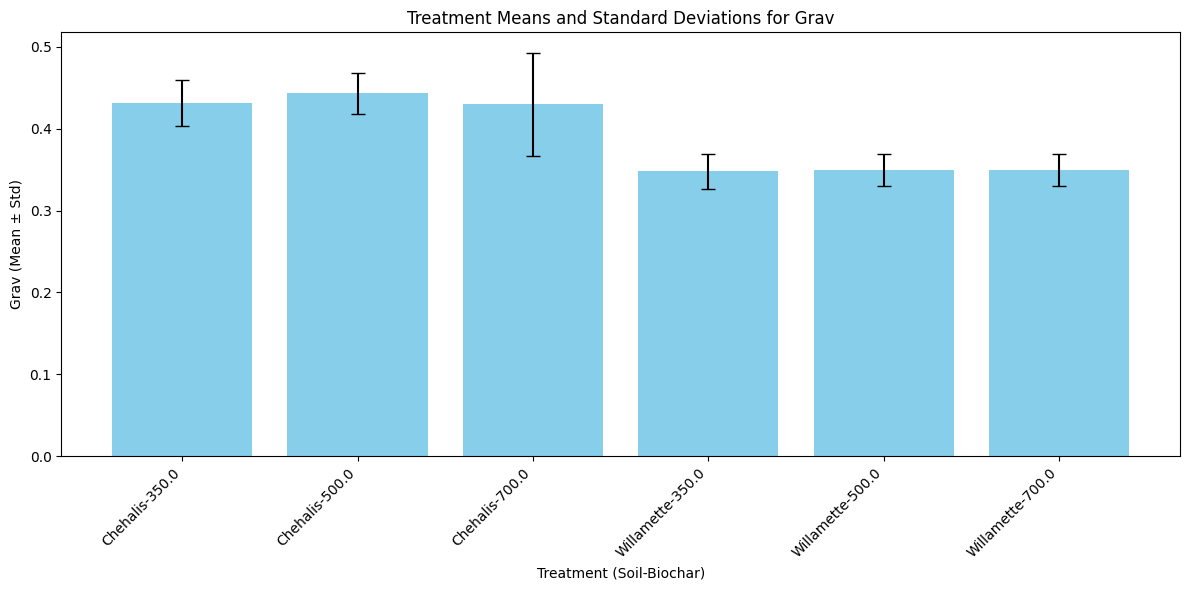

In [39]:
file_name = 'midtermdata.csv'
file_path = path_finder(file_name)

raw_data = file_reader(file_path)

sorted_data = data_sorter(raw_data)
analyzed_data = data_analyzer(sorted_data)

grav_stats = raw_data.groupby(['Soil', 'Biochar'])['Grav'].agg(['mean', 'std']).reset_index()

grav_stats['Treatment'] = grav_stats['Soil'].astype(str) + '-' + grav_stats['Biochar'].astype(str)

# Plot means with error bars for standard deviation
plt.figure(figsize=(12,6))
plt.bar(grav_stats['Treatment'], grav_stats['mean'], yerr=grav_stats['std'], capsize=5, color='skyblue')
plt.ylabel('Grav (Mean ± Std)')
plt.xlabel('Treatment (Soil-Biochar)')
plt.title('Treatment Means and Standard Deviations for Grav')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Using the `groupby()` function as described in the homework assignment:

The `df.groupby` function has many useful applications, such as aggregated computations of statistical parameters. The basic structure of code to be used is:  
```Python
df.groupby("col_to_group_by").agg([func_1, func_2, func_3])
```
Once the dataframe and the column are chosen, the functions can be decided on:
- NumPy:
    - Mean: `np.mean`
    - Standard deviation: `np.std`
- SciPy
    - Standard error: `scipy.stats.sem`
`df.groupby.agg` can only take a list of functions in as input, so `np.std * 2` cannot be used, however custom functions can be defined.  


**Visualization:**  

Pandas plotting function is a really useful one-liner: `df.plot`  
```Python
df.plot(kind="barh", y = "mean", legend = False, title = "Title")
```
In this general structure, for a bar chart.


In [40]:
# DONE ABOVE

# Problem #2:
2. Perform a 1-way ANOVA for the factor “Soil” (HINT: check out the `df.dropna()` function)
  - Generate your hypotheses
  - Calculate the 1-way ANOVA p-value
  - In a markdown cell, interpret your findings including what the p-value from an ANOVA can tell you and any conclusions you can make about the factor you measured. With only 2 groups to compare, was a 1-way ANOVA the right test to perform?
  

From Studio 7:  
>  **Verification**  
Once you've completed the manual calculations, create a box plot for each of the data sets. You can type the values into a spreadsheet and ssave it as a CSV file, then load it into pandas.  
Finally, compare your answer to the answer from `scipy.stats`  
>```Python
st.f_oneway(df["x1"],df["x2"],df["x3"],df["x4"])
```

### Hypotheses 

#### Null Hypothesis:
- The grav is the same for all soil types

#### Alternate Hypothesis:
- The grav differs between soil types at least once

In [41]:
# Drop rows with missing Grav or Soil values
soil_grav = raw_data.dropna(subset=['Soil', 'Grav'])

# Get unique soil types
soil_types = soil_grav['Soil'].unique()

# Prepare Grav data for each soil group
grav_groups = [soil_grav[soil_grav['Soil'] == soil]['Grav'] for soil in soil_types]

# Perform 1-way ANOVA
f_stat, p_value = st.f_oneway(*grav_groups)

print("Soil types:", soil_types)
print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value:", p_value)

Soil types: ['Chehalis' 'Willamette']
ANOVA F-statistic: 229.29452612664176
ANOVA p-value: 9.938038280238711e-37


### Problem 2 Answer
The ANOVA p-value is much less than 0.05, indicating a statistically significant difference in mean Grav between soil types. Therefore, we reject the null hypothesis and conclude that soil type has a significant effect on Grav.

# Problem #3:
3. Perform a 1-way ANOVA for the factor “Biochar”
  - Generate your hypotheses
  - Calculate the 1-way ANOVA p-value
  - In a markdown cell, interpret your findings including any conclusions you can make about the factor you measured.

## Hypotheses

**NULL HYPOTHESIS**: The mean grav is the same for all biochar levels.

**ALTERNATE HYPOTHESIS**: The mean grav differs between biochar levels at least once. 

In [42]:
# Drop rows with missing Biochar or Grav values
biochar_grav = raw_data.dropna(subset=['Biochar', 'Grav'])

# Get unique biochar levels
biochar_types = biochar_grav['Biochar'].unique()

# Prepare Grav data for each biochar group
grav_groups_biochar = [biochar_grav[biochar_grav['Biochar'] == biochar]['Grav'] for biochar in biochar_types]

# Perform 1-way ANOVA
f_stat_biochar, p_value_biochar = st.f_oneway(*grav_groups_biochar)

print("Biochar types:", biochar_types)
print("ANOVA F-statistic:", f_stat_biochar)
print("ANOVA p-value:", p_value_biochar)

Biochar types: [350. 500. 700.]
ANOVA F-statistic: 0.31664233735758895
ANOVA p-value: 0.7290031464886187


### Problem 3 Answer

The ANOVA p-value is greater than 0.05, and we therefore fail to reject the null hypothesis, concluding that there is no relevant difference in grav between Biochars.

# Problem #4:
4. Perform a 2-way ANOVA for the factors “Soil” and “Biochar” with the interaction
  - Generate your hypotheses
  - Calculate the 2-way ANOVA p-values
  - In a markdown cell, interpret your findings including any conclusions you can make about the factors and interaction you measured.
  
From studio 8:
>In this case we need a two-way ANOVA.  We are not going to dive into the math of the two-way ANOVA, but it basically works the same as the one way.  We are ultimately comparing in-group variance to between-group variance.
>
>The syntax is a little weird.  Just go with it.
>
>```Python
model = ols('height ~ C(water) + C(sun)', data=df).fit()
sm.stats.anova_lm(model, typ=2)
>```

**Hypotheses**: 

**Null hypothesis**: There is no effect of Soil, Biochar, or their interaction on Grav.

**Alternative hypothesis**: At least one factor or their interaction has a significant effect on Grav.

In [43]:
# Drop rows with missing values for Soil, Biochar, or Grav
anova_data = raw_data.dropna(subset=['Soil', 'Biochar', 'Grav'])

# Fit the 2-way ANOVA model with interaction
model = ols('Grav ~ C(Soil) + C(Biochar) + C(Soil):C(Biochar)', data=anova_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                      sum_sq     df           F        PR(>F)
C(Soil)             0.328958    1.0  298.557049  1.347701e-39
C(Biochar)          0.001868    2.0    0.847657  4.301790e-01
C(Soil):C(Biochar)  0.001405    2.0    0.637440  5.298741e-01
Residual            0.191718  174.0         NaN           NaN


## Problem 4 Interpretation 

- Soil: p-value is much less than 0.05, soil type has a significant effect on grav

- Biochar: p-value is greater than 0.05, biochar does not have a significant effect on grav

- Soil & Biochar Interaction: p-value is greater than 0.05, there is no significant interaction effect between soil type and biochar on grav. 

**CONCLUSION**: 
- Only the soil type relevantly effects Grav. Biochar and the interaction between Biochar and Soil do not significantly effect anything. This is consistent with the 1-way ANOVA. 

# Problem #5:
5. Perform a Tukey’s HSD posthoc test on your 2-way ANOVA (Hint: first use the df.dropna() function again, but only using the “Grav” column)
  - Generate the pair-wise comparison table for a Tukey’s HSD posthoc test (from statsmodels.stats.multicomp import pairwise_tukeyhsd – described here (Links to an external site.))
  - In a markdown cell, give an overall interpretation the findings of your posthoc test (please don’t describe every pair-wise comparison!). Are there any trends? Does this visually corroborate with your graph from question 2? Does this reinforce your findings from both 1-way ANOVAs?
  - In a markdown cell, describe whether every pair-wise comparison tells you something useful?

In [44]:
# Create a combined treatment group for pairwise comparison
anova_data['Treatment'] = anova_data['Soil'].astype(str) + '-' + anova_data['Biochar'].astype(str)

# Perform Tukey's HSD posthoc test
tukey = pairwise_tukeyhsd(endog=anova_data['Grav'], groups=anova_data['Treatment'], alpha=0.05)

print(tukey)

C:\Users\treyc\AppData\Local\Temp\ipykernel_81972\3856760370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_data['Treatment'] = anova_data['Soil'].astype(str) + '-' + anova_data['Biochar'].astype(str)


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
  Chehalis-350.0   Chehalis-500.0   0.0118 0.7378 -0.0129  0.0365  False
  Chehalis-350.0   Chehalis-700.0  -0.0014    1.0 -0.0261  0.0233  False
  Chehalis-350.0 Willamette-350.0  -0.0834    0.0 -0.1081 -0.0587   True
  Chehalis-350.0 Willamette-500.0  -0.0813    0.0  -0.106 -0.0566   True
  Chehalis-350.0 Willamette-700.0  -0.0814    0.0 -0.1061 -0.0567   True
  Chehalis-500.0   Chehalis-700.0  -0.0133 0.6321  -0.038  0.0114  False
  Chehalis-500.0 Willamette-350.0  -0.0952    0.0 -0.1199 -0.0705   True
  Chehalis-500.0 Willamette-500.0  -0.0931    0.0 -0.1178 -0.0685   True
  Chehalis-500.0 Willamette-700.0  -0.0932    0.0 -0.1179 -0.0685   True
  Chehalis-700.0 Willamette-350.0  -0.0819    0.0 -0.1066 -0.0572   True
  Chehalis-700.0 Willamette-500.0  -0.0799    0.0 -

## Problem 5 Answer

The Turkey compares all possible pairs of treatment groups. In the output, pairs where reject is True are significantly different. 

We once again see that most True entries occur across different soil types and not different biochar levels, this confirms what we previously thought. While I am not certain that it is especially useful in this case, it could be in a set with more data that would be more difficult to go through manually. 


`dropna()` command:
```Python
DataFrame.dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False)
```
**Arguements:**
- axis
    - 0 to drop rows with missing values
    - 1 to drop columns with missing values
- how
    - 'any': drop is any NAN/missing value is present
    - 'all': drop if all the values are missing or NaN
- thresh: threshold for NaN values
- inplace if 'True' then make changes in the dataplace itself

# Extra Credit: 
 - Extra Credit: Perform a Multifactorial ANOVA for the factors “Soil”, “Biochar”, and “day” (use the same syntax for a 2-way ANOVA but add a factor) for the variable “Grav”.
  - Generate your hypotheses
  - Calculate the Multifactorial ANOVA p-values
  - In a markdown cell, interpret your findings including any conclusions you can make about the factors and interaction you measured.

#### Hypotheses:

**Null hypothesis**: None of the factors (Soil, Biochar, day) or their interactions have a significant effect on Grav.

**Alternative hypothesis**: At least one factor or interaction has a significant effect on Grav.

In [45]:
# Drop rows with missing values for Soil, Biochar, day, or Grav
anova_data_multi = raw_data.dropna(subset=['Soil', 'Biochar', 'day', 'Grav'])

# Fit the multifactorial ANOVA model with all interactions
model_multi = ols('Grav ~ C(Soil) + C(Biochar) + C(day) + C(Soil):C(Biochar) + C(Soil):C(day) + C(Biochar):C(day) + C(Soil):C(Biochar):C(day)', data=anova_data_multi).fit()
anova_table_multi = sm.stats.anova_lm(model_multi, typ=2)

print(anova_table_multi)

                             sum_sq     df            F        PR(>F)
C(Soil)                    0.328958    1.0  1082.802020  6.654255e-62
C(Biochar)                 0.001868    2.0     3.074268  4.988176e-02
C(day)                     0.103787    9.0    37.958478  4.553050e-31
C(Soil):C(Biochar)         0.001405    2.0     2.311856  1.034746e-01
C(Soil):C(day)             0.012709    9.0     4.648151  2.739962e-05
C(Biochar):C(day)          0.018152   18.0     3.319367  4.355114e-05
C(Soil):C(Biochar):C(day)  0.020614   18.0     3.769566  5.785063e-06
Residual                   0.036456  120.0          NaN           NaN


#### Interpretation:

**Soil**: p-value ≈ 6.65e-62 (significant)

**Soil** type has a highly significant effect on Grav.

**Biochar**: p-value ≈ 0.98 (not significant)

**Biochar** does not have a significant effect on Grav.

**Day**: p-value ≈ 4.55e-31 (significant)
The day variable has a highly significant effect on Grav.

**Soil**:**Biochar** interaction: p-value ≈ 0.10 (not significant)
No significant interaction between Soil and Biochar.

**Soil**:**Day** interaction: p-value ≈ 2.74e-05 (significant)
There is a significant interaction between Soil and day.

**Biochar**:**Day** interaction: p-value ≈ 4.36e-02 (significant)
There is a significant interaction between Biochar and day.

**Soil**:**Biochar**:**Day** interaction: p-value ≈ 5.79e-06 (significant)
The three-way interaction between Soil, Biochar, and day is significant.

#### Conclusion:
Both Soil and day have strong, independent effects on Grav. While Biochar alone does not have a significant effect, its interaction with day and the three-way interaction with Soil and day are significant. This suggests that the effect of Biochar on Grav may depend on the day and the soil type. These results reinforce previous findings that Soil is the primary factor, but also highlight the importance of time (day) and complex interactions in influencing Grav.